In [1]:
import numpy as np
import matplotlib.pyplot as plt

from alpub_autoencoder.autoencoder_utils import read_alpub_data
from PIL import Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [4]:
ALPUB_PATH = '../../Datasets/alpub_v2/images'

In [5]:
X,Y = read_alpub_data(path=ALPUB_PATH)

Processing Alpha
Processing Beta
Processing Chi
Processing Delta
Processing Epsilon
Processing Eta
Processing Gamma
Processing Iota
Processing Kappa
Processing Lambda
Processing LunateSigma
Processing Mu
Processing Nu
Processing Omega
Processing Omicron
Processing Phi
Processing Pi
Processing Psi
Processing Rho
Processing Tau
Processing Theta
Processing Upsilon
Processing Xi
Processing Zeta


In [6]:
Y.shape

(205797, 24)

In [7]:
X.shape

(205797, 70, 70, 3)

In [8]:
# Convert the RGB images to grayscale
X_gray = []
for img in X:
    image_gray = Image.fromarray(img).convert("L")
    X_gray.append(np.array(image_gray))

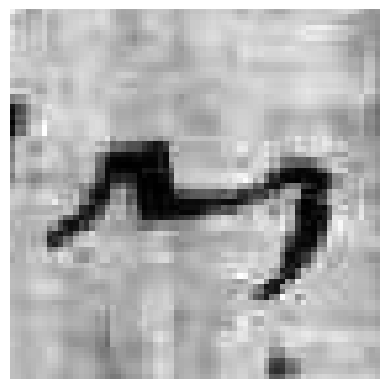

In [9]:
# Display the grayscale image
plt.imshow(X_gray[100000], cmap="gray")
plt.axis("off")
plt.show()

In [10]:
X_in = np.array(X_gray).reshape(len(X_gray), -1)

In [11]:
X_in.shape

(205797, 4900)

In [12]:
# Test-train split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets while preserving label balance
X_train, X_test, Y_train, Y_test = train_test_split(X_in, Y, test_size=0.1, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, stratify=Y_train)

In [13]:
print("Train images shape:",X_train.shape)
print("Train labels shape:",Y_train.shape)
print("Test images shape:",X_test.shape)
print("Test labels shape:",Y_test.shape)
print("Validation images shape:",X_val.shape)
print("Validation labels shape:",Y_val.shape)

Train images shape: (166695, 4900)
Train labels shape: (166695, 24)
Test images shape: (20580, 4900)
Test labels shape: (20580, 24)
Validation images shape: (18522, 4900)
Validation labels shape: (18522, 24)


In [14]:
#Autoencoder Implementation

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

In [15]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
class CharacterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        self.labels = torch.FloatTensor(labels)

        self.images = self.images.to(device)
        self.labels = self.labels.to(device)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [17]:
train_dataset = CharacterDataset(X_train, Y_train)
test_dataset = CharacterDataset(X_test, Y_test)
val_dataset = CharacterDataset(X_val, Y_val)

In [18]:
#Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, latent_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Training model with 10 latent dimensions...
Epoch [1/10], Train Loss: 1804.6271, Test Loss: 1294.6048
Epoch [2/10], Train Loss: 824.8790, Test Loss: 701.2716
Epoch [3/10], Train Loss: 673.6779, Test Loss: 647.2079
Epoch [4/10], Train Loss: 645.8137, Test Loss: 627.8526
Epoch [5/10], Train Loss: 641.2512, Test Loss: 626.1951
Epoch [6/10], Train Loss: 637.3635, Test Loss: 661.7477
Epoch [7/10], Train Loss: 635.4112, Test Loss: 624.3119
Epoch [8/10], Train Loss: 633.5182, Test Loss: 625.9598
Epoch [9/10], Train Loss: 633.1187, Test Loss: 622.9277
Epoch [10/10], Train Loss: 633.0876, Test Loss: 625.2748


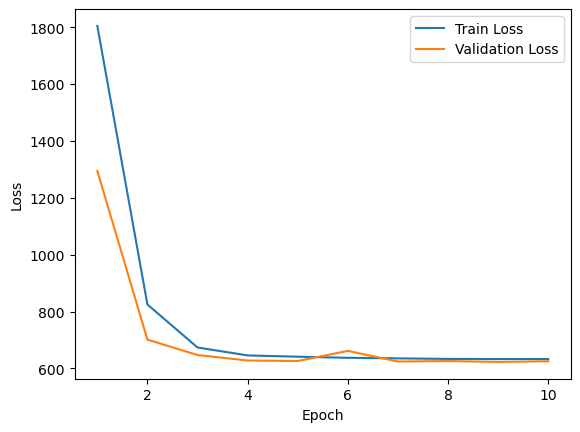

Training model with 25 latent dimensions...
Epoch [1/10], Train Loss: 1310.9808, Test Loss: 728.8221
Epoch [2/10], Train Loss: 584.5044, Test Loss: 510.4297
Epoch [3/10], Train Loss: 433.4626, Test Loss: 416.3916
Epoch [4/10], Train Loss: 409.8543, Test Loss: 417.8263
Epoch [5/10], Train Loss: 404.4830, Test Loss: 393.9593
Epoch [6/10], Train Loss: 404.3407, Test Loss: 395.7060
Epoch [7/10], Train Loss: 401.0578, Test Loss: 394.4894
Epoch [8/10], Train Loss: 401.7844, Test Loss: 392.1100
Epoch [9/10], Train Loss: 400.6616, Test Loss: 398.9954
Epoch [10/10], Train Loss: 400.5505, Test Loss: 392.9286


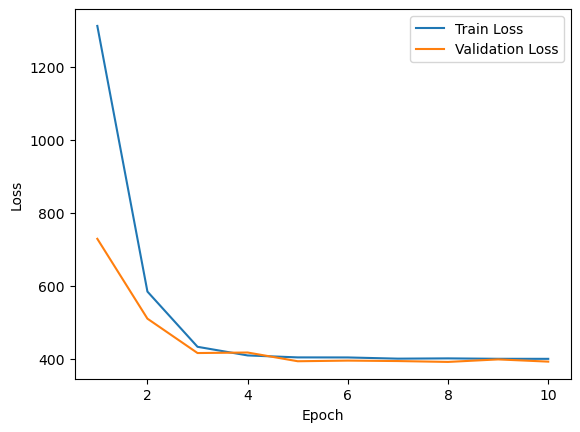

Training model with 100 latent dimensions...
Epoch [1/10], Train Loss: 819.5562, Test Loss: 356.3304
Epoch [2/10], Train Loss: 288.0652, Test Loss: 205.7285
Epoch [3/10], Train Loss: 887.2378, Test Loss: 195.9049
Epoch [4/10], Train Loss: 189.2164, Test Loss: 258.4932
Epoch [5/10], Train Loss: 169.9448, Test Loss: 162.7448
Epoch [6/10], Train Loss: 168.7722, Test Loss: 244.4190
Epoch [7/10], Train Loss: 474.9470, Test Loss: 151.2536
Epoch [8/10], Train Loss: 155.6607, Test Loss: 147.5888
Epoch [9/10], Train Loss: 156.6764, Test Loss: 155.4956
Epoch [10/10], Train Loss: 406.7198, Test Loss: 157.8692


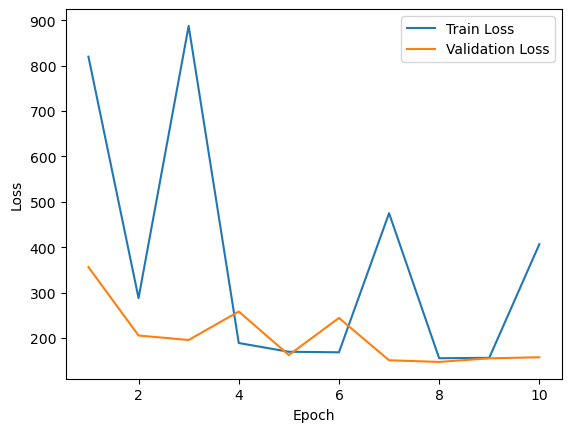

Training model with 500 latent dimensions...
Epoch [1/10], Train Loss: 431.2918, Test Loss: 146.7347
Epoch [2/10], Train Loss: 4025.5045, Test Loss: 117.9739
Epoch [3/10], Train Loss: 146.0335, Test Loss: 111.8620
Epoch [4/10], Train Loss: 2176.9672, Test Loss: 120.0232
Epoch [5/10], Train Loss: 126.4624, Test Loss: 94.9568
Epoch [6/10], Train Loss: 2968.1717, Test Loss: 125.3836
Epoch [7/10], Train Loss: 102.8956, Test Loss: 100.9223
Epoch [8/10], Train Loss: 103.2160, Test Loss: 89.7968
Epoch [9/10], Train Loss: 3351.1555, Test Loss: 165.3933
Epoch [10/10], Train Loss: 100.7861, Test Loss: 72.9864


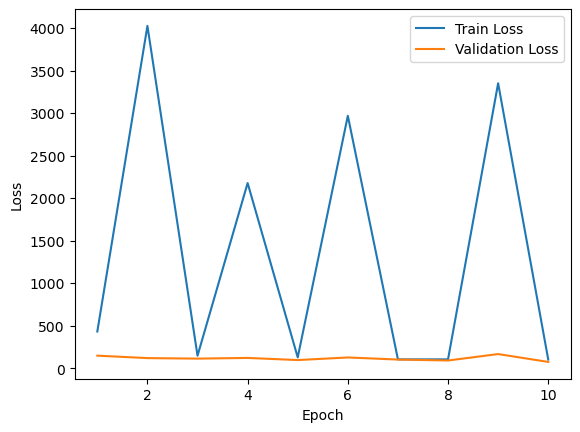

In [27]:
for latent_dim in [10,25,100,500]: # train for [2,5,10,20,100] latent dims

    print("Training model with", latent_dim,"latent dimensions...")

    input_dim = 4900  # Dimensionality of the input data

    model = Autoencoder(input_dim, latent_dim)
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    batch_size = 64
    best_test_loss = float('inf')
    best_model_state = None

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0

        # Training
        model.train()
        for batch in train_loader:
            images, labels = batch

            # Forward pass
            reconstructions = model(images)
            loss = criterion(reconstructions, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch

                # Forward pass
                reconstructions = model(images)
                loss = criterion(reconstructions, images)

                test_loss += loss.item() * images.size(0)

            test_loss /= len(val_loader.dataset)
            test_losses.append(test_loss)

            # Check if current model has the lowest test loss so far
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model_state = model.state_dict().copy()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Plotting train and test loss
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Load the best model state (lowest test loss)
    model.load_state_dict(best_model_state)
    torch.save(model.state_dict(), '../models/alpub_autoencoder_dim_'+str(latent_dim)+'.pt')

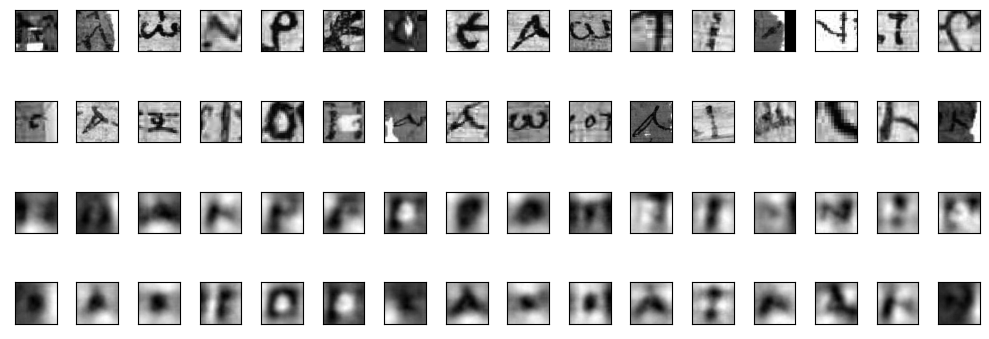

In [24]:
# Set the model to evaluation mode
model.eval()

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Get a batch of test data
test_batch = next(iter(test_loader))
test_images, _ = test_batch

# Pass the test data through the model
with torch.no_grad():
    reconstructions = model(test_images)

# Plot the original images and their reconstructions
fig, axes = plt.subplots(nrows=4, ncols=batch_size // 4, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    if i < batch_size // 2:
        # Plot original image
        ax.imshow(test_images[i].cpu().numpy().reshape(70, 70), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    else:
        # Plot reconstructed image
        ax.imshow(reconstructions[i - batch_size // 2].cpu().numpy().reshape(70, 70), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])


plt.tight_layout()
plt.show()